# Lab 2: GP classification and Sparse Gaussian Processes
### Gaussian Process Summer School 2018
_written by Fariba Yousefi and Juan José Giraldo and adapted from notebooks by James Hensman and Alan Saul._

This lab is designed to introduce Gaussian Process classification and sparse Gaussian processes focusing on the variational frameworks developed by Hensman et. al. in "Gaussian Processes for Big Data" and "Scalable Variational Gaussian Process Classification" available from http://www.auai.org/uai2013/prints/papers/244.pdf and http://proceedings.mlr.press/v38/hensman15.pdf respectively. The notebook in based on the Python library `GPy`$^\dagger$ which handles the kernels, regression and optimisation of hyperparameter, allowing us to easily access the results we want.

$^\dagger$`GPy`: A Gaussian process framework in Python (since 2012). Available from http://github.com/SheffieldML/GPy

## Getting started

Make sure that `GPy` is already installed on your machine. You should be using Python 3.5 (or above). A set of instructions for setting up your environment are [available from the GPSS site](http://gpss.cc/gpss18/getting_started).

We start defining some useful libraries and functions to plot the examples to cover:

In [2]:
import GPy
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
# import climin
import numpy as np
# from scipy.io import loadmat
import os
np.random.seed(1)
# import pods

### GP Classification

In GPs we have prior and likelihood that are gaussian and because of conjugacy property the posterior is gaussian.
However, in the classification case our likelihood is not gaussian anymore and it is Bernouli likelihood.
Because of the non-gaussian likelihood the posterior can't be calculated analytically and should be approximated.
There are different approximation techniques such as Laplace, Expectation Propogation, Variational Inference, etc.
If we sample from GP we will have continous values, but in the classification case we want our values between 
to be 0 and 1. To get the desired values, we use probit function and squash $f$ through 
logistic function to get values 0 and 1. 

Text(0,0.5,'$f(x)$')

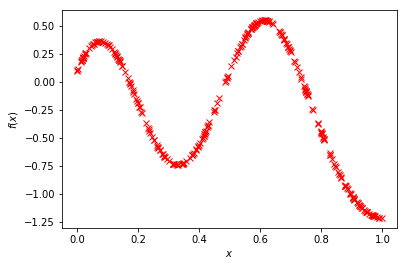

In [3]:
k = GPy.kern.RBF(1, variance=1, lengthscale=0.2)
X = np.random.rand(300,1)
# draw latent function f
f = np.random.multivariate_normal(np.zeros(300), k.K(X))
plt.plot(X, f, 'rx')
plt.xlabel('$x$');
plt.ylabel('$f(x)$')

Text(0,0.5,'$\\sigma(f(x))$')

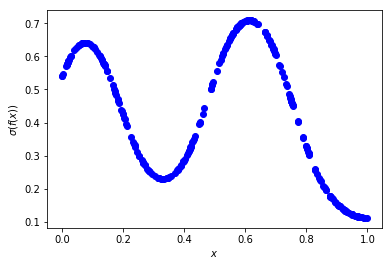

In [4]:
bern = GPy.likelihoods.Bernoulli()
# squashing the latent function
p_s = bern.gp_link.transf(f) 
plt.plot(X, p_s, 'bo')
plt.xlabel('$x$');
plt.ylabel('$\sigma(f(x))$')

Now we can draw samples from the squashed latent functions;

In [5]:
y = bern.samples(f).reshape(-1,1)
# You can plot the samples you are drawing with the code below;
# plt.ylim(-0.1, 1.1)
# plt.plot(X, y, 'kx', mew=2);
# plt.title('Bernoulli draws')
# plt.xlabel('$x$')
# plt.ylabel('$y$')

In [6]:
#  This model is designed for EP with dafaults settings
m = GPy.models.GPClassification(X,y)

Text(0.5,1,'Posterior over latent probabilities')

 /home/wil/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


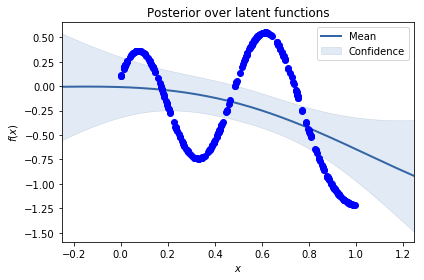

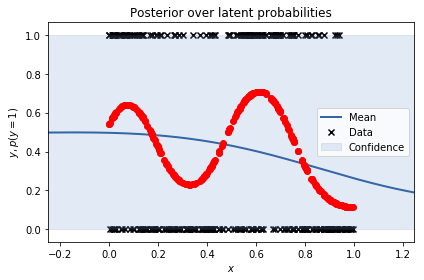

In [7]:
m.plot_f()
plt.plot(X, f, 'bo')
plt.title("Posterior over latent functions")
plt.ylabel('$f(x)$');plt.xlabel('$x$')

m.plot()
plt.plot(X, p_s, 'ro')
plt.ylabel('$y, p(y=1)$');plt.xlabel('$x$')
plt.title("Posterior over latent probabilities")

We use Laplace to approximate the posterior and marginal likelihood.
In the above plots because of the lengthscale that we gave to the function, is not very well defined so we need
to optimise the parameters of the kernel to get the better fit.

In [8]:
m.optimize('lbfgs', messages=True, max_iters=200)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s19  006   1.790948e+02   1.785868e-01 
    00s26  016   1.789978e+02   5.957344e-09 
Runtime:     00s26
Optimization status: Converged



 /home/wil/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


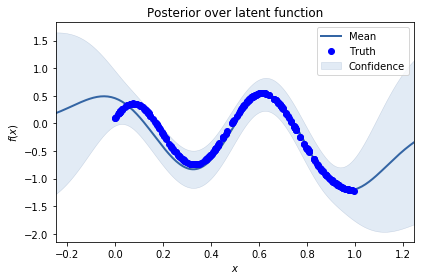

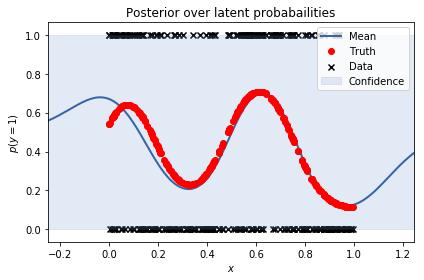

In [9]:
m.plot_f()
plt.plot(X, f, 'bo', label='Truth')
plt.title("Posterior over latent function")
plt.ylabel('$f(x)$');plt.xlabel('$x$')
plt.legend()

m.plot()
plt.plot(X, p_s, 'ro', label='Truth')
plt.title("Posterior over latent probabailities")
plt.ylabel('$p(y=1)$');plt.xlabel('$x$')
plt.legend()

### Excersice;
Please change the dataset to mnist dataset and apply both Laplace and EP approximations.
Check how they are different from each other and how long each takes.
Below is a little help to use Laplace and EP in GPy.

In [10]:
# laplace_inf = GPy.inference.latent_function_inference.Laplace()
# ep_inf = GPy.inference.latent_function_inference.EP()
# m = GPy.core.GP(X, y, kernel=k, likelihood=bern, inference_method=laplace_inf)

In [131]:
def regression_plot1D(m,Nplots=1):
    fig1, axes = plt.subplots(1, Nplots, figsize=(10,5))
    axes = np.reshape(axes,(-1,Nplots))
    ax = axes[0,0]
    ax.plot(m.X_all, m.Y_all, 'kx', alpha=0.1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('SVI Y prediction with data')
    _ = m.plot(which_data_ycols=[0], plot_limits=(m.X_all.min(),m.X_all.max()), ax=ax)
    ax.set_xlim((m.X_all.min(),m.X_all.max()))
def gridParams():
    mins = [-3.25,-2.85 ]
    maxs = [ 3.65, 3.4 ]
    nGrid = 50
    xspaced = np.linspace( mins[0], maxs[0], nGrid )
    yspaced = np.linspace( mins[1], maxs[1], nGrid )
    xx, yy = np.meshgrid( xspaced, yspaced )
    Xplot = np.vstack((xx.flatten(),yy.flatten())).T
    return xx, yy, Xplot

def plot(m, ax):
    col1 = '#0172B2'
    col2 = '#CC6600'
    xx, yy, Xplot = gridParams()
    p = m.predict(Xplot)[0]
    ax.plot(Xtrain[:,0][Ytrain[:,0]==1], Xtrain[:,1][Ytrain[:,0]==1], 'o',label='c1', color=col1, mew=0, alpha=0.5)
    ax.plot(Xtrain[:,0][Ytrain[:,0]==0], Xtrain[:,1][Ytrain[:,0]==0], 'o',label='c2', color=col2, mew=0, alpha=0.5)
    if hasattr(m, 'Z'):
        ax.plot(m.Z.values[:,0], m.Z.values[:,1],'ko', label='ip',mew=0, ms=4)
        #ax.legend(loc=1, fontsize=13)
    CS = ax.contour(xx, yy, p.reshape(xx.shape),10, linewidths=0.9, zorder=100)
    fig.colorbar(CS, ax=ax,aspect=20)    

## 1. Sparse GP with Gaussian Likelihood

The non-parametric formulation that characterize the GPs makes the inference prohibitive when the number of data observations is large. The computational cost of inference in GPs is $O(N^3)$ in  general,  where $N$ is  the  number  of  data observations. In order to deal with this problem a sparse GP aims to augment its probability space with a set of $M$ _inducing variables_. The idea is to find a posterior distribution over that smaller set of $M$ inducing variables instead of over the large number $N$ of data observations, therefore $M<<N$. The challenge is to find a proper set of inducing variables and model parameters that best approximate the full GP (check http://www.auai.org/uai2013/prints/papers/244.pdf for mathematical details). Let's build a regression example with a sparse GP.

In [132]:
# We set the number of data observations to generate
N=2000
np.random.seed(101)
X1 = np.random.rand(N)[:, None]
# We create an output with a mixture of sin functions and add some random noise
Y1 = np.sin(6*X1)+np.sin(85*X1)+np.sin(16*X1)+np.sin(36*X1) + 0.1*np.random.randn(N,1)

We create a model called SVGP which stands for "sparse variational Gaussian process model". This model will recieve as arguments the data observations or inputs $X \in \mathbb{R}^{N\times D}$, the output $Y \in \mathbb{R}^{N}$, the set of inducing points $Z \in \mathbb{R}^{M\times D}$, the kernel function and the likelihood. For this case the likelihood is a Gaussian distribution commonly used for regression problems.

In [133]:
#This is an example of just one Dimension
D = 1
#We set the number of inducing points
num_inducing = 20
from scipy.cluster.vq import kmeans
np.random.seed(101)
#A good initialization for inducing points is the Kmeans algorithm
Z = kmeans(X1, num_inducing)[0]
#We create the model mreg
mreg = GPy.core.SVGP(X1, Y1, Z, GPy.kern.RBF(D) + GPy.kern.White(D), GPy.likelihoods.Gaussian())
#We set and fix a small variance for the white kernel to avoid ill-conditioning
mreg.kern.white.variance = 1.0e-6
mreg.kern.white.fix()
#This line can be uncomment to check the behaviour of fixing the inducing points to not optimize them
#mreg.Z.fix()
#We run the optimization lbfgsb with a maximum of iterations and messages True
mreg.optimize('lbfgsb', max_iters=2500, messages=1)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s08  0004   1.492338e+05   3.683583e+11 
    00s19  0009   5.217073e+03   7.668717e+13 
    02s20  0306   4.068086e+03   7.599442e+11 
    08s22  1264   2.629849e+03   3.417285e+07 
    11s23  1746   2.537550e+03   5.200693e+09 
    15s94  2502   2.473606e+03   1.216001e+07 
Runtime:     15s94
Optimization status: Maximum number of f evaluations reached



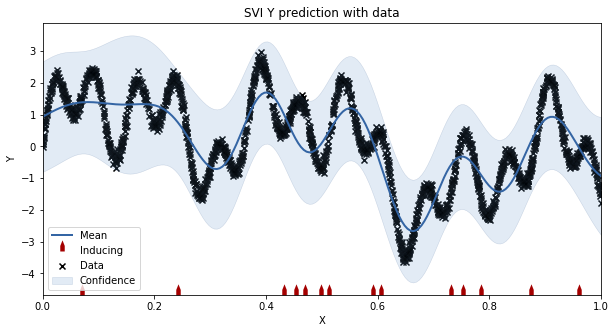

In [134]:
regression_plot1D(mreg)

### Exercise 1

Did you find a confident regression for the above example?  

(a) What if you explore the effect of changing the number of inducing points and/or fixing them?, report your findings.

From the first day Lab1 you learned different sorts of kernel covariances to use.

(b) Could you improve the regression choosing another kind of kernel covariance? which ones behave better?

## 1.1 Stochastic Variational Inference for Sparse GP
The objective function that is optimized in the SVGP model is commonly known as the evidence lower bound or ELBO in the context of variational inference (check https://arxiv.org/pdf/1601.00670.pdf for mathamatical details). The ELBO for the variational sparse GP is written as:
\begin{align}
	\mathcal{L}= \mathbb{E}_{q(\mathbf{f})}\Big[\log p(\mathbf{y}|\mathbf{f})\Big]-\mathbb{D}_{KL}(q_{\mathbf{u}}||p_{\mathbf{u}}),	
\end{align}
where $p(\mathbf{y}|\mathbf{f})=\prod_{n=1}^N\log p(y_n|f_n)$ is the likelihood (e.g. in the last regression model we used the Gaussian likelihood) and $\mathbb{D}_{KL}(\cdot||\cdot)$ represents the Kullback-Leibler divergence (more details from http://proceedings.mlr.press/v38/hensman15.pdf eq(19)). We will not go in deep with the mathematical aspect, but we'll focus on the first term to the right hand side of:  
\begin{align}
	\mathcal{L}= \sum_{n=1}^{N}\mathbb{E}_{q(f_n)}[\log p(y_n|f_n)]-\mathbb{D}_{KL}(q_{\mathbf{u}}||p_{\mathbf{u}}),	
\end{align}
where we can notice that there is a sum over $N$ expectations to solve. Given that $N$ can be really large, then stochastic inference suggests to take randomly a mini-batch of size $B$ from the whole data set to solve those expectations. Therefore the problem reduces to a noisy version of the ELBO which it is even easier to compute and can be written as:
\begin{align}
	\mathcal{L}= \frac{N}{B}\sum_{b=1}^{B}\mathbb{E}_{q(f_b)}[\log p(y_b|f_b)]-\mathbb{D}_{KL}(q_{\mathbf{u}}||p_{\mathbf{u}})\quad\quad (1).
\end{align}

The next example is equal to the first one, but making use of stochastic inference where we sample randombly from the data set a mini-batch of size $B$ at each inference iteration. So we first define a callback() function to be used with a different kind of optimizers, e.g Adadelta or RMSprop which are adaptive gradient methods for optimization. 

In [135]:
def callbackreg(i):
    #We eval the function to monitor it improvement and plotting and the end
    ELBOreg.append(mreg.log_likelihood())
    #Stop after 2500 iterations
    if i['n_iter'] > 500:
        print('Optimization status: Maximum number of Iterations Reached')
        return True
    return False

Here we set the model similar to the way done before, but defining a batch and passing it to the model.

In [136]:
ELBOreg=[]
Dim = 1
#Define the size of the mini-batch to sample from the dataset
batch=1
#Define the number of inducing points
num_inducing = 35
from scipy.cluster.vq import kmeans
np.random.seed(101)
#Initialize inducing points with Kmeans
Z = 1.0*kmeans(X1, num_inducing)[0]
mreg = GPy.core.SVGP(X1, Y1, Z, GPy.kern.RBF(Dim) + GPy.kern.White(Dim), GPy.likelihoods.Gaussian(),batchsize=batch)
mreg.kern.white.variance = 1.0e-6
mreg.kern.white.fix()
#mreg.Z.fix()

array([0])

We define an optimizer from the climin library and run it by calling back...

In [137]:
opt = climin.Adadelta(mreg.optimizer_array, mreg.stochastic_grad, step_rate=0.1, momentum=0.9)
info = opt.minimize_until(callbackreg)

Optimization status: Maximum number of Iterations Reached


Now we plot the regression done by the sparse GP model (left) and we plot the behavior of the negative ELBO (right)
in the optimization process.

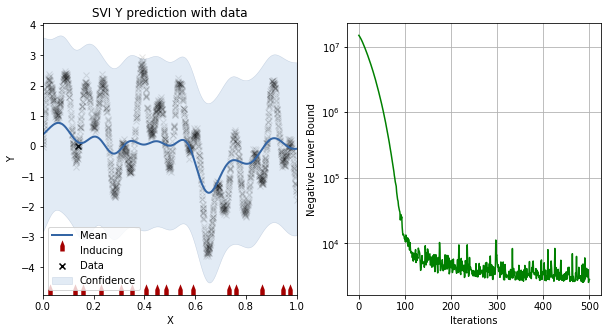

In [138]:
regression_plot1D(mreg,2)

plt.subplot(1, 2, 2)
plt.plot(-np.array(ELBOreg), linestyle='-',color='g')
plt.legend(loc=1)
plt.grid(True)
plt.yscale('symlog')
#plt.xscale('log')
plt.ylabel('Negative Lower Bound')
plt.xlabel('Iterations')

### Exercise 2

Now that you have more experience to set the kernel covariance and the inducing points: 

(a) What if you set properly this regression model with the covariance and number of inducing points you found the best in the last exercise, and also explore the effect of changing the size of the batch for optimizing the model?

What happens when the mini-batch size is big or when it tends to one? 
Are the number of iterations (in the callback function) enough to reach convergence? does it have any relation to the size of the mini-batch?

## 2. Sparse GP with Non-Gaussian Likelihood

The case of Gaussian likelihood involves straighforward computation of the expectations that appear in the bound of Eq.(1). Nonetheless when the likelihood is non-Gaussian it is necessary to appeal to sampling or quadrature methods to approximate those expectations. The following example presents a binary classification for the 2D benchmark banana dataset. For this case we set a likelihood Bernoulli since the purpose is to model if an observation belongs to class zero (0) or one (1).  

In [139]:
#The banana dataset has 5300 data observations, therefore we define N as the number of
#training data, while the remainig data are used to test the performance of the model.
N = 3700
#We load the banana dataset
Xdata = np.genfromtxt('banana.csv', delimiter=',')

In [140]:
#We make the split of the data to train and test
Ntotal,Dim = Xdata.shape
Dim = Dim-1
np.random.seed(101)
Xdata = Xdata[np.random.permutation(Ntotal)] #Hacer permutacion justa
Ytrain = Xdata[0:N,Dim:Dim+1]
#We ensure the output to be zeros (0) and ones (1)
Ytrain[np.where(Ytrain==-1)] = 0  #Be awared that for a Bernoulli we use 1 or 0 not -1

Ytest = Xdata[N:Ntotal,Dim:Dim+1]
Ytest[np.where(Ytest==-1)] = 0
Xtrain = Xdata[0:N,0:Dim]
Xtest = Xdata[N:Ntotal,0:Dim]

In [141]:
#We define the callback function for the case of bernoulli likelihood
def callback(i):
    #We monitor the ELBO 
    ELBO.append(m.log_likelihood())
    #We calculate the Test Log-Loss metric to check the model performance in the test data set
    pred_Test, _ = m.predict(Xtest)
    pred_Test[np.where(pred_Test==1.0)] = 1.0-1.0e-15
    pred_Test[np.where(pred_Test == 0.0)] = 1.0e-15
    aux_loss=-(Ytest * np.log(pred_Test) + (1.0 - Ytest) * np.log(1.0 - pred_Test))
    log_loss.append(aux_loss.mean())
    #Stop after 500 iterations
    if i['n_iter'] > 500:
        return True
    return False

In [142]:
# Run sparse classification with increasing number of inducing points
Ms = [4,6]   # This variable contains different number of inducing points to build different models and compare
Nmodels = len(Ms)
batch = 50

ELBO=[]
log_loss=[]
myELBOS=[]
myLogLoss=[]
models = []

#This for aims to train the different models with different number of inducing points
for index, num_inducing in enumerate(Ms):
    # kmeans for selecting Z
    from scipy.cluster.vq import kmeans

    np.random.seed(101)
    Z = 1.0 * kmeans(Xtrain, num_inducing)[0]

    m = GPy.core.SVGP(Xtrain, Ytrain, Z=Z, kernel=GPy.kern.RBF(Dim) + GPy.kern.White(Dim),
                          likelihood=GPy.likelihoods.Bernoulli(), batchsize=batch)

    m.kern.white.variance = 1.0e-5
    m.kern.white.fix()
    #Here we fix the inducing points to not be optimize
    m.Z.fix()

    opt = climin.Adadelta(m.optimizer_array, m.stochastic_grad, step_rate=0.1, momentum=0.9)

    info = opt.minimize_until(callback)
    models.append(m)
    myELBOS.append(ELBO)
    myLogLoss.append(log_loss)
    ELBO=[]
    log_loss=[]

Here we plot the different models from left to right. The First row show the data set with the contour curves which
separate the two classes and the location of the inducing points (black). The second row shows the negative ELBO behavior and the third shows the test log-loss to indicate how relevant is the model in the test set (smaller negative ELBO and test log- loss means better performance).

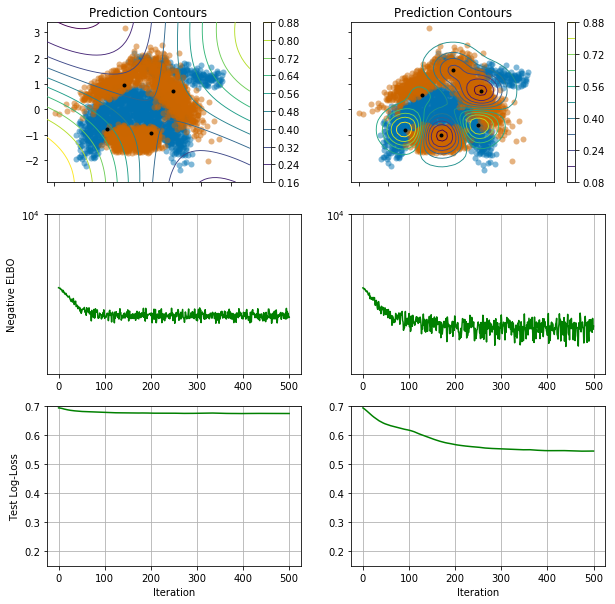

In [143]:
fig, axes = plt.subplots(3, Nmodels, figsize=(Nmodels*5, Nmodels*5), sharex=True, sharey=True)
axes = np.reshape(axes,(-1,Nmodels))
for i, m in enumerate(models):
    plot(m, axes[0,i])
    axes[0, i].set_title('Prediction Contours')

for i,(EL,loss) in enumerate(zip(myELBOS,myLogLoss)):
   plt.subplot(3,Nmodels,i+Nmodels+1)
   plt.plot(-np.array(EL), linestyle='-',color='g')
   plt.legend(loc=1, fontsize=13)
   if i==0:
       plt.ylabel('Negative ELBO',fontsize=10)
       mini = np.min(-np.array(EL)) 
   plt.grid(True)
   plt.yscale('symlog')
   plt.ylim(mini-mini/2,10000)
   plt.subplot(3, Nmodels, i + 2 * Nmodels + 1)
   plt.plot(np.array(loss), linestyle='-', color='g')
   plt.legend(loc=1, fontsize=13)
   if i==0:
       plt.ylabel('Test Log-Loss',fontsize=10)
   plt.xlabel('Iteration', fontsize=10)
   plt.ylim(0.15,0.7)
   plt.grid(True) 

We can print each model and see their information:

In [144]:
for i in range(Nmodels):
   print(models[i])


Name : SVGP
Objective : 2437.79564333
Number of Parameters : 25
Number of Optimization Parameters : 16
Updates : True
Parameters:
  SVGP.                |          value  |  constraints  |  priors
  inducing_inputs      |         (4, 2)  |     fixed     |        
  sum.rbf.variance     |  1.63216838887  |      +ve      |        
  sum.rbf.lengthscale  |  4.51842005955  |      +ve      |        
  sum.white.variance   |          1e-05  |   +ve fixed   |        
  q_u_chol             |        (10, 1)  |               |        
  q_u_mean             |         (4, 1)  |               |        

Name : SVGP
Objective : 2157.63839888
Number of Parameters : 42
Number of Optimization Parameters : 29
Updates : True
Parameters:
  SVGP.                |            value  |  constraints  |  priors
  inducing_inputs      |           (6, 2)  |     fixed     |        
  sum.rbf.variance     |  0.0808940512751  |      +ve      |        
  sum.rbf.lengthscale  |    0.46608804854  |      +ve      |  

### Exercise 3

In the binary classification example the inducing points were fixed with Kmeans algorithm and not optimized.

(a) What do you think, is it better to fix the inducing points with Kmeans or optimize them? Play with the algorithm and comment about it.


(b) What number of inducing points would you suggest as the most feasible to define for this data set? How did you decide it?

(c) have you tried a very big number of inducing points? What happens in that case? 